In [1]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

import warnings
warnings.filterwarnings("ignore")

## Combine and Prepare dataset

In [2]:

COLUMN_RENAME_MAP = {
    "TARİX": "timestamp",
    "XÜSUSİ ÇƏKİ\n(kq/m3)": "density_kg_m3",
    "TƏZYİQLƏR\nFƏRQİ (kPa)": "pressure_diff_kpa",
    "TƏZYİQ (kPa)": "pressure_kpa",
    "TEMPERATUR\n(C)": "temperature_c",
    "SAATLIQ\nSƏRF(min m3)": "hourly_flow_m3",
    "SƏRF (min m3)": "total_flow_m3",
}


def load_and_tag_csv(file_path: Path) -> pd.DataFrame:
    df = pd.read_csv(file_path)

    # Rename columns BEFORE concat
    df = df.rename(columns=COLUMN_RENAME_MAP)

    # Add location column
    df = df.copy()
    df["location"] = file_path.stem

    print(f"Loaded {file_path.name}: {len(df):,} rows")

    return df


def combine_location_files(file_paths: list[Path]) -> pd.DataFrame:
    dataframes = []
    total_expected_rows = 0

    for path in file_paths:
        df = load_and_tag_csv(path)
        dataframes.append(df)
        total_expected_rows += len(df)

    combined_df = pd.concat(
        dataframes,
        axis=0,
        ignore_index=True
    )

    print("-" * 50)
    print(f"Expected total rows : {total_expected_rows:,}")
    print(f"Combined DF rows   : {len(combined_df):,}")
    print(
        "Row loss detected  :",
        "YES" if total_expected_rows != len(combined_df) else "NO"
    )

    # Validation
    required_columns = set(COLUMN_RENAME_MAP.values()) | {"location"}
    missing = required_columns - set(combined_df.columns)

    if missing:
        raise RuntimeError(f"Missing expected columns: {missing}")

    return combined_df


if __name__ == "__main__":
    files = [
        Path("../data/Mardakan.csv"),
        Path("../data/Sumqayit.csv"),
        Path("../data/Turkan.csv"),
    ]

    df = combine_location_files(files)

    print("-" * 50)
    print("Final columns:")
    print(df.columns.tolist())
    print("Unique locations:", df["location"].unique())

    # Optional save
    # df.to_csv("../data/combined_locations_clean.csv", index=False)

Loaded Mardakan.csv: 57,978 rows
Loaded Sumqayit.csv: 58,011 rows
Loaded Turkan.csv: 57,978 rows
--------------------------------------------------
Expected total rows : 173,967
Combined DF rows   : 173,967
Row loss detected  : NO
--------------------------------------------------
Final columns:
['timestamp', 'density_kg_m3', 'pressure_diff_kpa', 'pressure_kpa', 'temperature_c', 'hourly_flow_m3', 'total_flow_m3', 'location']
Unique locations: ['Mardakan' 'Sumqayit' 'Turkan']


In [3]:
df

,timestamp,density_kg_m3,pressure_diff_kpa,pressure_kpa,temperature_c,hourly_flow_m3,total_flow_m3,location
0,01-01-2018 01:00,0.73703,6.1342,593.740,10.513,4.494,107.860,Mardakan
1,01-01-2018 02:00,0.73703,5.8290,606.206,10.330,4.430,106.316,Mardakan
2,01-01-2018 03:00,0.73703,5.9273,581.200,9.987,4.374,104.987,Mardakan
3,01-01-2018 04:00,0.73703,6.0022,561.711,10.138,4.325,103.795,Mardakan
4,01-01-2018 05:00,0.73703,5.6887,586.612,10.315,4.304,103.287,Mardakan
...,...,...,...,...,...,...,...,...
173962,14-08-2024 07:00,0.74916,0.2317,470.583,23.165,0.152,3.636,Turkan
173963,14-08-2024 08:00,0.74916,0.2661,477.322,26.667,0.162,3.881,Turkan
173964,14-08-2024 09:00,0.74916,0.3641,484.269,30.954,0.187,4.496,Turkan
173965,14-08-2024 10:00,0.74916,0.3352,486.630,34.979,0.180,4.323,Turkan


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173967 entries, 0 to 173966
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   timestamp          173967 non-null  object 
 1   density_kg_m3      170289 non-null  float64
 2   pressure_diff_kpa  170289 non-null  float64
 3   pressure_kpa       170289 non-null  float64
 4   temperature_c      170289 non-null  float64
 5   hourly_flow_m3     170289 non-null  float64
 6   total_flow_m3      170289 non-null  float64
 7   location           173967 non-null  object 
dtypes: float64(6), object(2)
memory usage: 10.6+ MB


In [5]:
df.describe()

,density_kg_m3,pressure_diff_kpa,pressure_kpa,temperature_c,hourly_flow_m3,total_flow_m3
count,170289.000000,170289.000000,170289.000000,170289.000000,170289.000000,170289.000000
mean,0.739360,9.209971,485.650572,16.324738,8.190251,196.566034
std,0.013998,8.030006,95.800057,17.369537,11.387239,273.293731
min,0.000000,-0.984000,0.000000,-34.568000,0.000000,0.000000
25%,0.727770,3.153700,411.840000,8.232000,1.035000,24.850000
50%,0.734700,7.382900,487.077000,15.212000,4.461000,107.056000
75%,0.752790,12.887300,561.744000,23.389000,7.097000,170.330000
max,1.000000,69.132000,770.969000,746.153000,56.990000,1367.770000


## Handle Null values

In [6]:
df.isnull().sum()

timestamp               0
density_kg_m3        3678
pressure_diff_kpa    3678
pressure_kpa         3678
temperature_c        3678
hourly_flow_m3       3678
total_flow_m3        3678
location                0
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
df.isnull().sum()

timestamp            0
density_kg_m3        0
pressure_diff_kpa    0
pressure_kpa         0
temperature_c        0
hourly_flow_m3       0
total_flow_m3        0
location             0
dtype: int64

## Convert Timestamp to Features

In [9]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d-%m-%Y %H:%M', errors='coerce')
df.dropna(subset=['timestamp'], inplace=True)
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year
df.set_index('timestamp', inplace=True)

df.head()

,density_kg_m3,pressure_diff_kpa,pressure_kpa,temperature_c,hourly_flow_m3,total_flow_m3,location,hour,day_of_week,month,year
timestamp,,,,,,,,,,,
2018-01-01 01:00:00,0.73703,6.1342,593.740,10.513,4.494,107.860,Mardakan,1,0,1,2018
2018-01-01 02:00:00,0.73703,5.8290,606.206,10.330,4.430,106.316,Mardakan,2,0,1,2018
2018-01-01 03:00:00,0.73703,5.9273,581.200,9.987,4.374,104.987,Mardakan,3,0,1,2018
2018-01-01 04:00:00,0.73703,6.0022,561.711,10.138,4.325,103.795,Mardakan,4,0,1,2018
2018-01-01 05:00:00,0.73703,5.6887,586.612,10.315,4.304,103.287,Mardakan,5,0,1,2018


## Prepare Data for Modeling

In [10]:
numerical_features = ['density_kg_m3', 'pressure_diff_kpa', 'pressure_kpa', 'temperature_c', 'hourly_flow_m3', 'total_flow_m3', 'hour', 'day_of_week', 'month', 'year']

numerical_features

['density_kg_m3',
 'pressure_diff_kpa',
 'pressure_kpa',
 'temperature_c',
 'hourly_flow_m3',
 'total_flow_m3',
 'hour',
 'day_of_week',
 'month',
 'year']

In [11]:
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

df[numerical_features].head()

,density_kg_m3,pressure_diff_kpa,pressure_kpa,temperature_c,hourly_flow_m3,total_flow_m3,hour,day_of_week,month,year
timestamp,,,,,,,,,,
2018-01-01 01:00:00,-0.166476,-0.383036,1.128285,-0.334595,-0.324597,-0.324582,-1.525482,-1.49889,-1.559794,-1.459478
2018-01-01 02:00:00,-0.166476,-0.421043,1.258410,-0.345130,-0.330217,-0.330232,-1.380702,-1.49889,-1.559794,-1.459478
2018-01-01 03:00:00,-0.166476,-0.408802,0.997387,-0.364878,-0.335135,-0.335095,-1.235922,-1.49889,-1.559794,-1.459478
2018-01-01 04:00:00,-0.166476,-0.399474,0.793952,-0.356184,-0.339438,-0.339456,-1.091142,-1.49889,-1.559794,-1.459478
2018-01-01 05:00:00,-0.166476,-0.438515,1.053880,-0.345994,-0.341282,-0.341315,-0.946362,-1.49889,-1.559794,-1.459478


In [12]:
df_encoded = pd.get_dummies(df, columns=['location'], prefix='location', dtype=int)

df_encoded.head()

,density_kg_m3,pressure_diff_kpa,pressure_kpa,temperature_c,hourly_flow_m3,total_flow_m3,hour,day_of_week,month,year,location_Mardakan,location_Sumqayit,location_Turkan
timestamp,,,,,,,,,,,,,
2018-01-01 01:00:00,-0.166476,-0.383036,1.128285,-0.334595,-0.324597,-0.324582,-1.525482,-1.49889,-1.559794,-1.459478,1,0,0
2018-01-01 02:00:00,-0.166476,-0.421043,1.258410,-0.345130,-0.330217,-0.330232,-1.380702,-1.49889,-1.559794,-1.459478,1,0,0
2018-01-01 03:00:00,-0.166476,-0.408802,0.997387,-0.364878,-0.335135,-0.335095,-1.235922,-1.49889,-1.559794,-1.459478,1,0,0
2018-01-01 04:00:00,-0.166476,-0.399474,0.793952,-0.356184,-0.339438,-0.339456,-1.091142,-1.49889,-1.559794,-1.459478,1,0,0
2018-01-01 05:00:00,-0.166476,-0.438515,1.053880,-0.345994,-0.341282,-0.341315,-0.946362,-1.49889,-1.559794,-1.459478,1,0,0


In [13]:
# Instantiate IsolationForest model
model = IsolationForest(random_state=42, contamination=0.01)

# Fit the model to the prepared data
model.fit(df_encoded)

print("Isolation Forest model trained successfully.")

Isolation Forest model trained successfully.


In [14]:
feature_columns = [col for col in df_encoded.columns if col not in ['anomaly', 'anomaly_score']]

anomaly_predictions = model.predict(df_encoded[feature_columns])
anomaly_scores = model.decision_function(df_encoded[feature_columns])

df_encoded['anomaly'] = anomaly_predictions
df_encoded['anomaly_score'] = anomaly_scores

df_encoded.head()

,density_kg_m3,pressure_diff_kpa,pressure_kpa,temperature_c,hourly_flow_m3,total_flow_m3,hour,day_of_week,month,year,location_Mardakan,location_Sumqayit,location_Turkan,anomaly,anomaly_score
timestamp,,,,,,,,,,,,,,,
2018-01-01 01:00:00,-0.166476,-0.383036,1.128285,-0.334595,-0.324597,-0.324582,-1.525482,-1.49889,-1.559794,-1.459478,1,0,0,1,0.065423
2018-01-01 02:00:00,-0.166476,-0.421043,1.258410,-0.345130,-0.330217,-0.330232,-1.380702,-1.49889,-1.559794,-1.459478,1,0,0,1,0.070054
2018-01-01 03:00:00,-0.166476,-0.408802,0.997387,-0.364878,-0.335135,-0.335095,-1.235922,-1.49889,-1.559794,-1.459478,1,0,0,1,0.073941
2018-01-01 04:00:00,-0.166476,-0.399474,0.793952,-0.356184,-0.339438,-0.339456,-1.091142,-1.49889,-1.559794,-1.459478,1,0,0,1,0.077967
2018-01-01 05:00:00,-0.166476,-0.438515,1.053880,-0.345994,-0.341282,-0.341315,-0.946362,-1.49889,-1.559794,-1.459478,1,0,0,1,0.078578


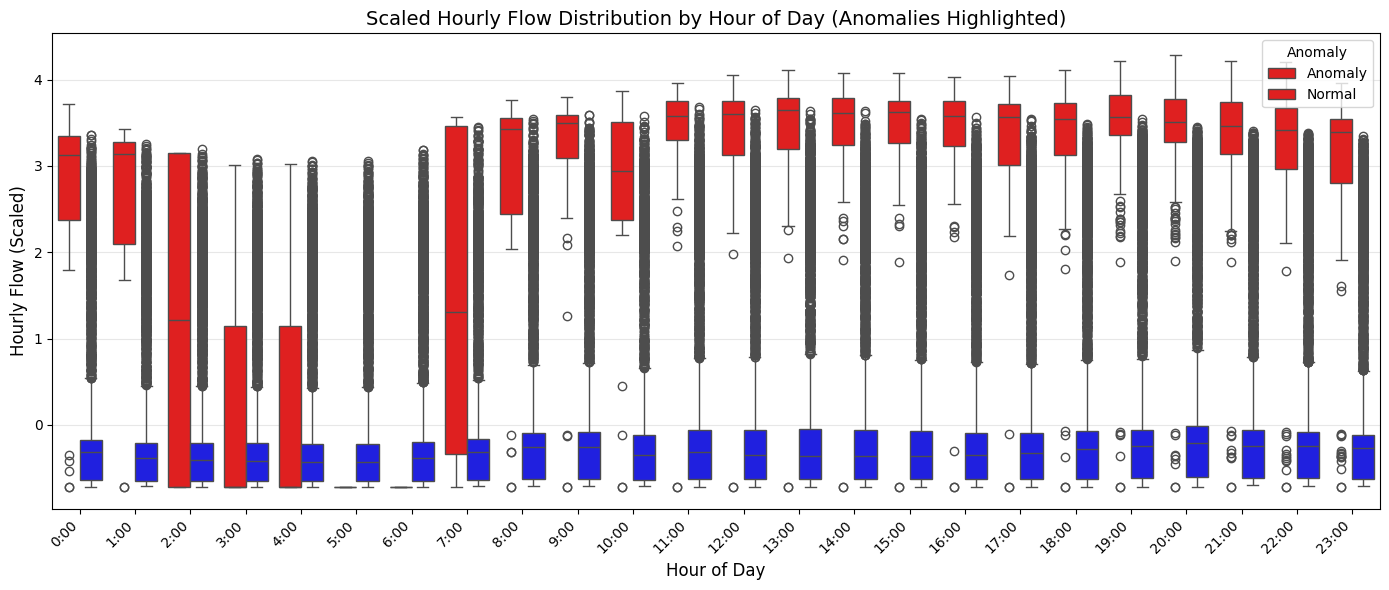

In [26]:
plt.figure(figsize=(14, 6))

# Convert anomaly column from string to integer
df_encoded['anomaly'] = df_encoded['anomaly'].astype(int)

# Create the boxplot
sns.boxplot(x='hour', y='hourly_flow_m3', hue='anomaly', data=df_encoded, 
           palette={1: 'blue', -1: 'red'})

plt.title('Scaled Hourly Flow Distribution by Hour of Day (Anomalies Highlighted)', fontsize=14)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Hourly Flow (Scaled)', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set custom x-axis labels (0-23 hours)
plt.xticks(ticks=range(0, 24), labels=[f'{h}:00' for h in range(24)])

plt.legend(title='Anomaly', labels=['Anomaly', 'Normal'], loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../charts/hourly_flow_by_hour_anomalies.png')
plt.show()

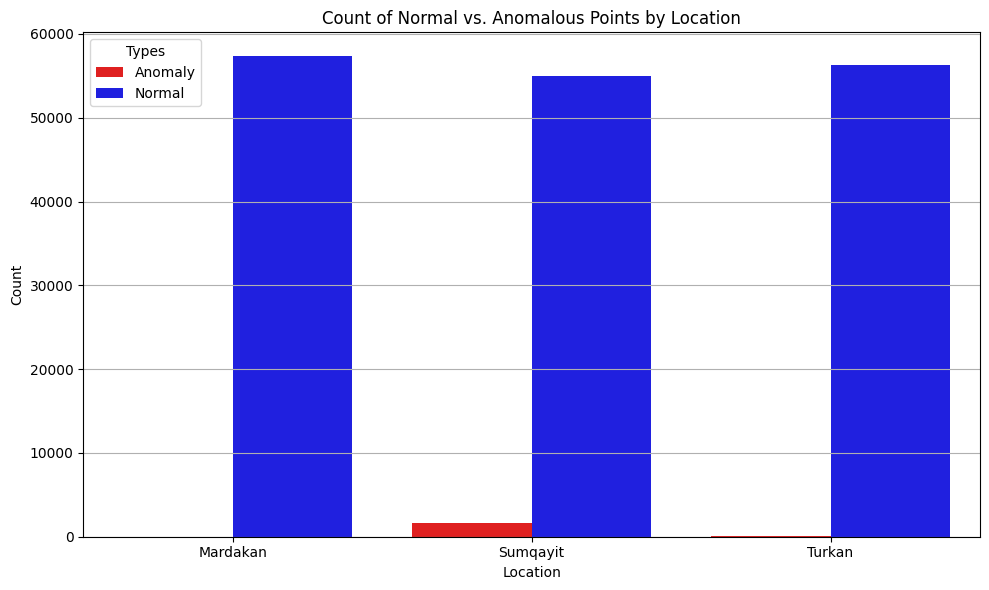

In [16]:
# Temporarily create a 'location_name' column for easier plotting
df_encoded['location_name'] = df_encoded[['location_Mardakan', 'location_Sumqayit', 'location_Turkan']].idxmax(axis=1).str.replace('location_', '')

plt.figure(figsize=(10, 6))
sns.countplot(x='location_name', hue='anomaly', data=df_encoded, palette={1: 'blue', -1: 'red'})
plt.title('Count of Normal vs. Anomalous Points by Location')
plt.xlabel('Location')
plt.ylabel('Count')
plt.legend(title='Types', labels=['Anomaly', 'Normal'])
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('../charts/anomalies_by_location.png')
plt.show()

# Drop the temporary column
df_encoded.drop(columns=['location_name'], inplace=True)

Data type of anomaly column: int64
Unique values in anomaly column: [ 1 -1]


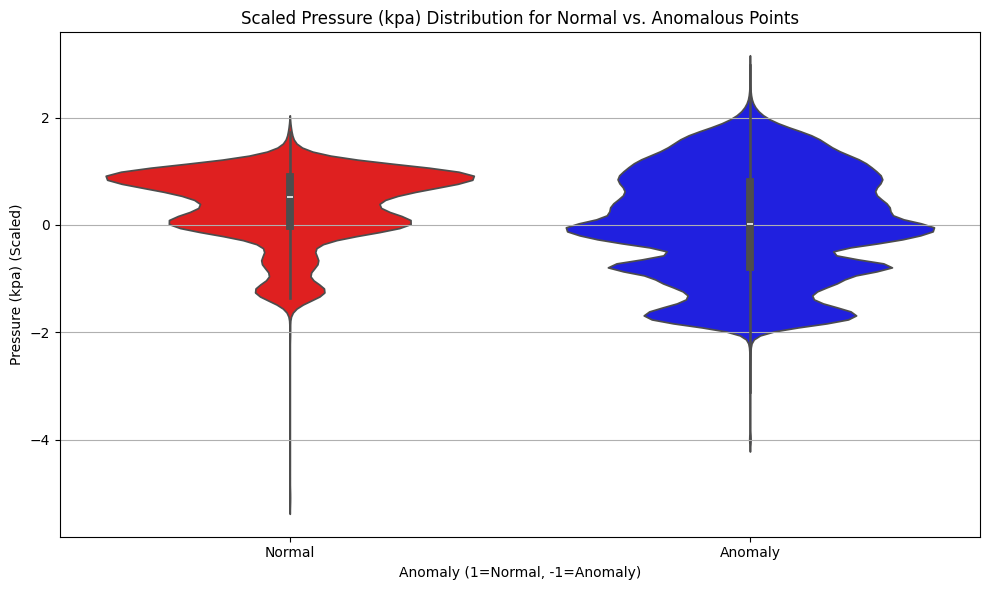

In [17]:
plt.figure(figsize=(10, 6))

# Check what type your anomaly column actually contains
print("Data type of anomaly column:", df_encoded['anomaly'].dtype)
print("Unique values in anomaly column:", df_encoded['anomaly'].unique())

# Use string keys in your palette
sns.violinplot(x='anomaly', y='pressure_kpa', data=df_encoded, palette={'1': 'blue', '-1': 'red'})

plt.title('Scaled Pressure (kpa) Distribution for Normal vs. Anomalous Points')
plt.xlabel('Anomaly (1=Normal, -1=Anomaly)')
plt.ylabel('Pressure (kpa) (Scaled)')
plt.xticks(ticks=[0, 1], labels=['Normal', 'Anomaly'])
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('../charts/pressure_distribution_anomalies.png')
plt.show()

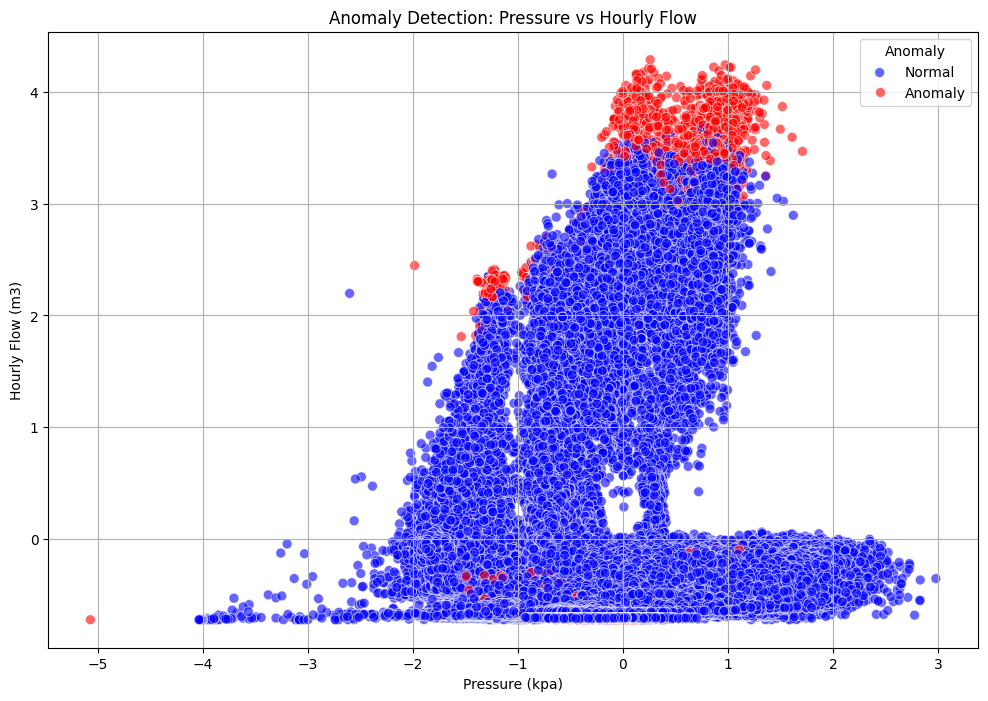

In [18]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_encoded,
    x='pressure_kpa',
    y='hourly_flow_m3',
    hue='anomaly', # Color by anomaly column
    palette={1: 'blue', -1: 'red'}, # Blue for normal, red for anomaly
    s=50, # Size of points
    alpha=0.6
)
plt.title('Anomaly Detection: Pressure vs Hourly Flow')
plt.xlabel('Pressure (kpa)')
plt.ylabel('Hourly Flow (m3)')
plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'])
plt.grid(True)
plt.savefig('../charts/anomaly_detection.png')
plt.show()


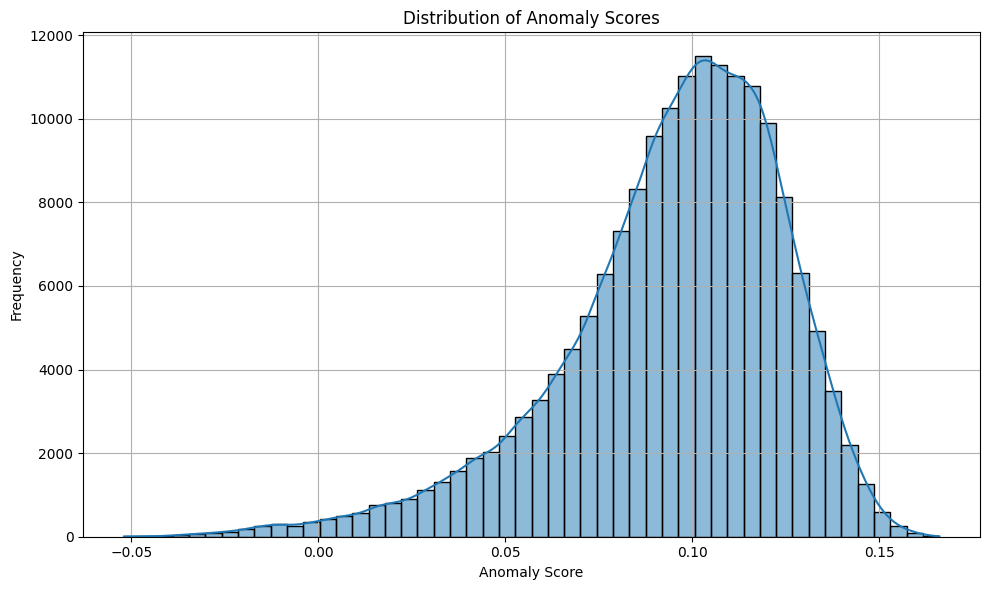

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(df_encoded['anomaly_score'], bins=50, kde=True)
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.savefig('../charts/anomaly_score_distribution.png')
plt.show()

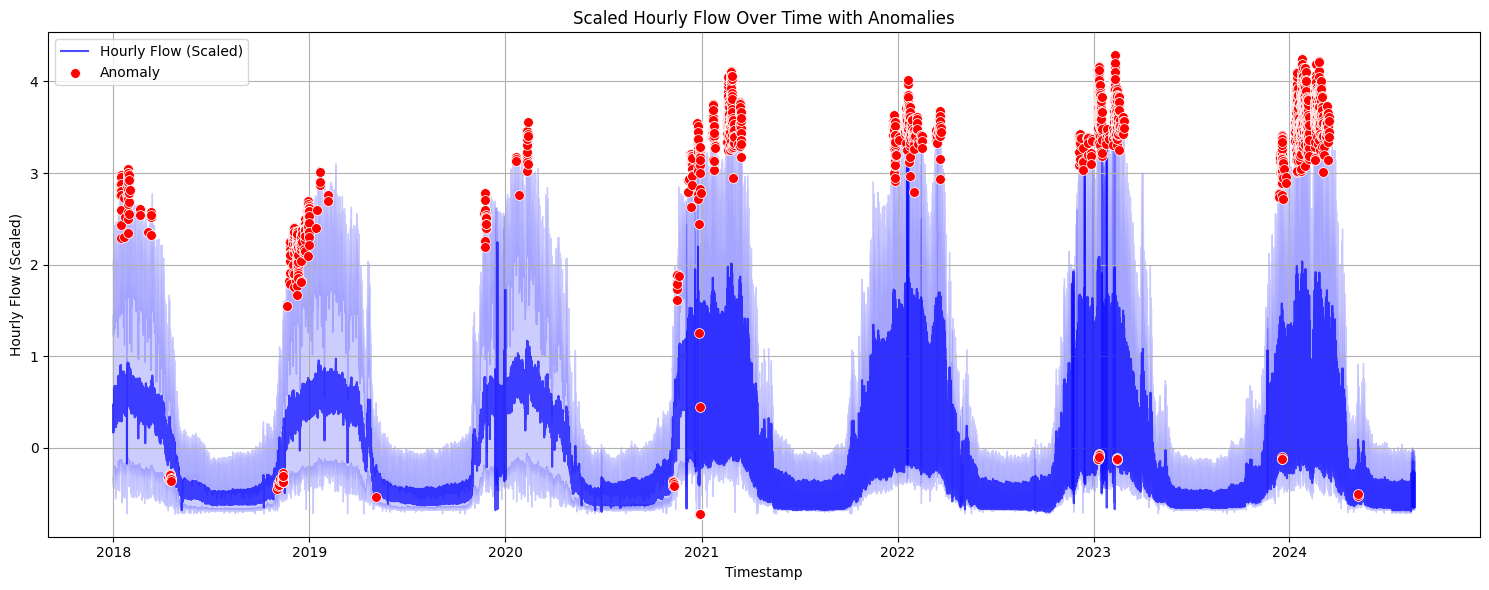

In [20]:
plt.figure(figsize=(15, 6))
sns.lineplot(x=df_encoded.index, y='hourly_flow_m3', data=df_encoded, color='blue', alpha=0.7, label='Hourly Flow (Scaled)')
anomalies = df_encoded[df_encoded['anomaly'] == -1]
sns.scatterplot(x=anomalies.index, y='hourly_flow_m3', data=anomalies, color='red', label='Anomaly', s=50, zorder=5)
plt.title('Scaled Hourly Flow Over Time with Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Hourly Flow (Scaled)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../charts/hourly_flow_anomalies_timeseries.png')
plt.show()

## Example prediction

In [21]:
# Define the filename for saving the model
model_filename = '../models/isolation_forest_model.joblib'

# Save the trained model to the file
joblib.dump(model, model_filename)

print(f"Trained Isolation Forest model saved to {model_filename}")

Trained Isolation Forest model saved to ../models/isolation_forest_model.joblib


In [22]:
# Define the filename for the saved model
model_filename = '../models/isolation_forest_model.joblib'

# Load the trained Isolation Forest model
loaded_model = joblib.load(model_filename)

print(f"Trained Isolation Forest model loaded from {model_filename}")

Trained Isolation Forest model loaded from ../models/isolation_forest_model.joblib


In [23]:
# Example of new data for prediction (mimicking the original df structure before preprocessing)
new_data = pd.DataFrame({
    'timestamp': ['01-01-2023 10:00'],
    'density_kg_m3': [0.75],
    'pressure_diff_kpa': [5.0],
    'pressure_kpa': [600.0],
    'temperature_c': [12.0],
    'hourly_flow_m3': [5.0],
    'total_flow_m3': [120.0],
    'location': ['Mardakan']
})

# Apply the same timestamp feature engineering as in training
new_data['timestamp'] = pd.to_datetime(new_data['timestamp'], format='%d-%m-%Y %H:%M', errors='coerce')
new_data['hour'] = new_data['timestamp'].dt.hour
new_data['day_of_week'] = new_data['timestamp'].dt.dayofweek
new_data['month'] = new_data['timestamp'].dt.month
new_data['year'] = new_data['timestamp'].dt.year

# Identify all feature columns used during training
# These are the numerical features plus the one-hot encoded location columns
# We get the list of location columns directly from df_encoded's columns
location_cols = [col for col in df_encoded.columns if col.startswith('location_')]
all_features = numerical_features + location_cols

# Create a dummy DataFrame for one-hot encoding to ensure all location columns are present
# and in the correct order, even if a new_data point doesn't have all locations
dummy_df_for_ohe = pd.DataFrame(columns=['location'])
dummy_df_for_ohe = pd.concat([dummy_df_for_ohe, new_data[['location']]], ignore_index=True)
new_data_encoded = pd.get_dummies(dummy_df_for_ohe, columns=['location'], prefix='location', dtype=int)

# Ensure all expected location columns are present, fill with 0 if not
for col in location_cols:
    if col not in new_data_encoded.columns:
        new_data_encoded[col] = 0

# Reindex to ensure correct order of one-hot encoded columns and remove duplicates
new_data_encoded = new_data_encoded[location_cols]

# Scale numerical features using the *same scaler* fitted on the training data
new_data[numerical_features] = scaler.transform(new_data[numerical_features])

# Combine numerical and one-hot encoded features
prepared_new_data = pd.concat([
    new_data[numerical_features].reset_index(drop=True),
    new_data_encoded.reset_index(drop=True)
], axis=1)

# Ensure column order matches the training data
prepared_new_data = prepared_new_data[all_features]

# Make prediction
anomaly_prediction = loaded_model.predict(prepared_new_data)
anomaly_score = loaded_model.decision_function(prepared_new_data)

# Interpret the prediction
if anomaly_prediction[0] == -1:
    print("The new data point is predicted to be an ANOMALY.")
else:
    print("The new data point is predicted to be NORMAL.")

print(f"Anomaly score: {anomaly_score[0]}")

The new data point is predicted to be NORMAL.
Anomaly score: 0.08463946650158671
